In [193]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
plt.style.use('fivethirtyeight')
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [194]:
# Load Data
address = 'C:\\Users\\Konstantin\\Downloads\\archive\\vaccinations.csv'
vaccines = pd.read_csv(address)
address = 'C:\\Users\\Konstantin\\Downloads\\archive (1)\\vaccination_all_tweets.csv'
tweets = pd.read_csv(address)

In [195]:
vaccines['date'] = pd.to_datetime(vaccines['date'])

# Check the type
type(vaccines['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [196]:
# Daily Vaccination
daily = vaccines[['location',  'iso_code',  'daily_vaccinations']]

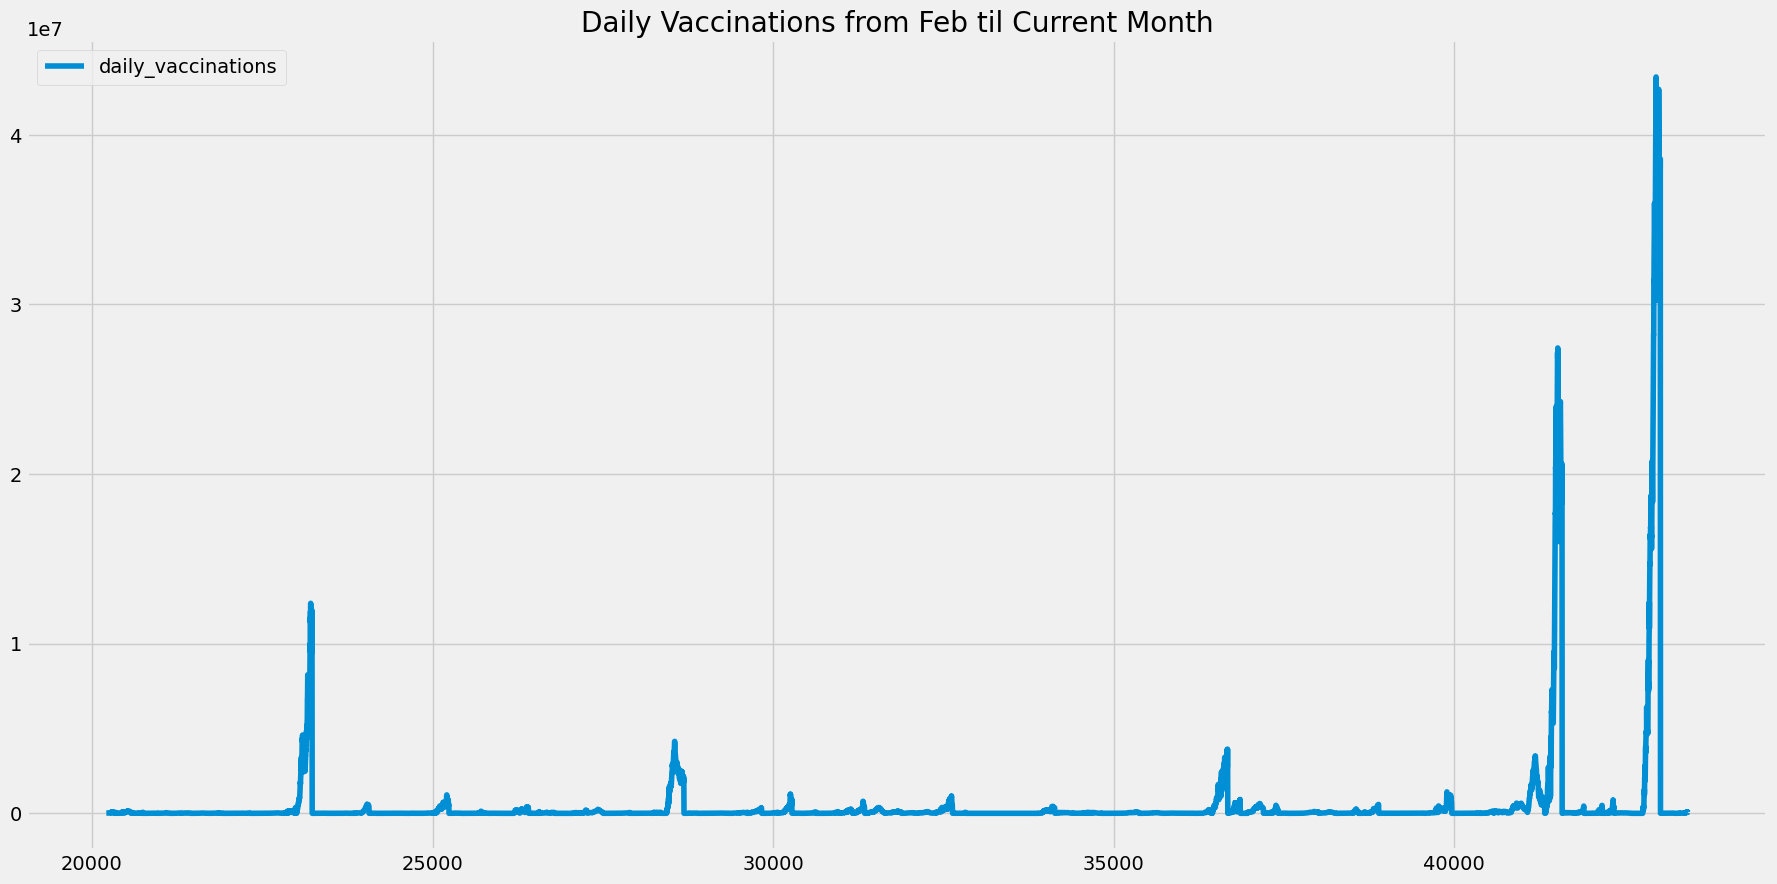

In [197]:
# Plotting data
plt.figure(figsize=(20, 10))
sns.lineplot(data=daily.loc['2021-02-22':])
plt.title('Daily Vaccinations from Feb til Current Month')
plt.show()

In [198]:
tweets['datedt'] = pd.to_datetime(tweets['date'])

In [199]:
tweets['date_only'] = tweets['datedt'].dt.date

In [200]:
tweets_agg_df = tweets.groupby(["date_only"])["text"].count().reset_index()
tweets_agg_df.columns = ["date_only", "count"]

In [201]:
def plot_time_variation(df, x='date_only', y='count', hue=None, size=1, title="", is_log=False):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    g = sns.lineplot(x=x, y=y, hue=hue, data=df)
    plt.xticks(rotation=90)
    if hue:
        plt.title(f'{y} grouped by {hue} | {title}')
    else:
        plt.title(f'{y} | {title}')
    if(is_log):
        ax.set(yscale="log")
    ax.grid(color='black', linestyle='dotted', linewidth=0.75)
    plt.show() 

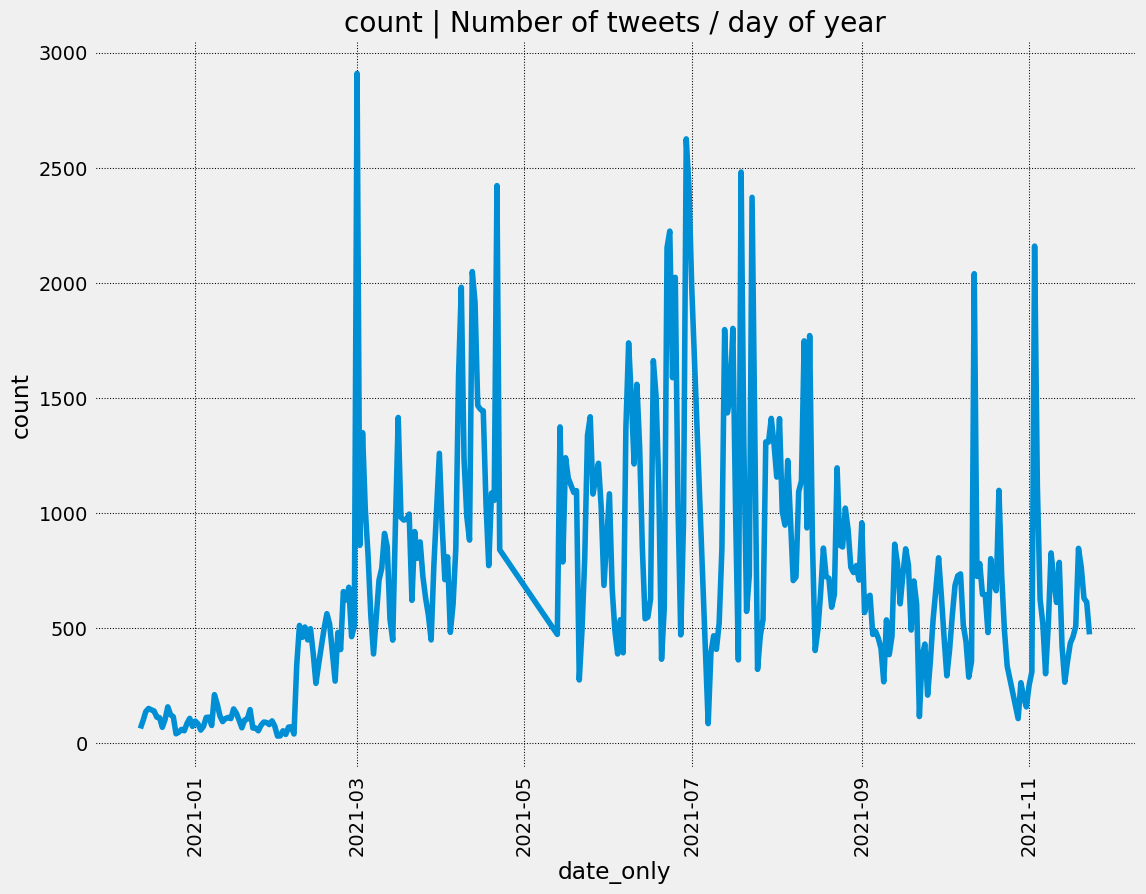

In [202]:
plot_time_variation(tweets_agg_df, title="Number of tweets / day of year",size=3)

In [203]:
tweets['date_only']

0         2020-12-20
1         2020-12-13
2         2020-12-12
3         2020-12-12
4         2020-12-12
             ...    
228202    2021-11-15
228203    2021-11-15
228204    2021-11-15
228205    2021-11-15
228206    2021-11-15
Name: date_only, Length: 228207, dtype: object

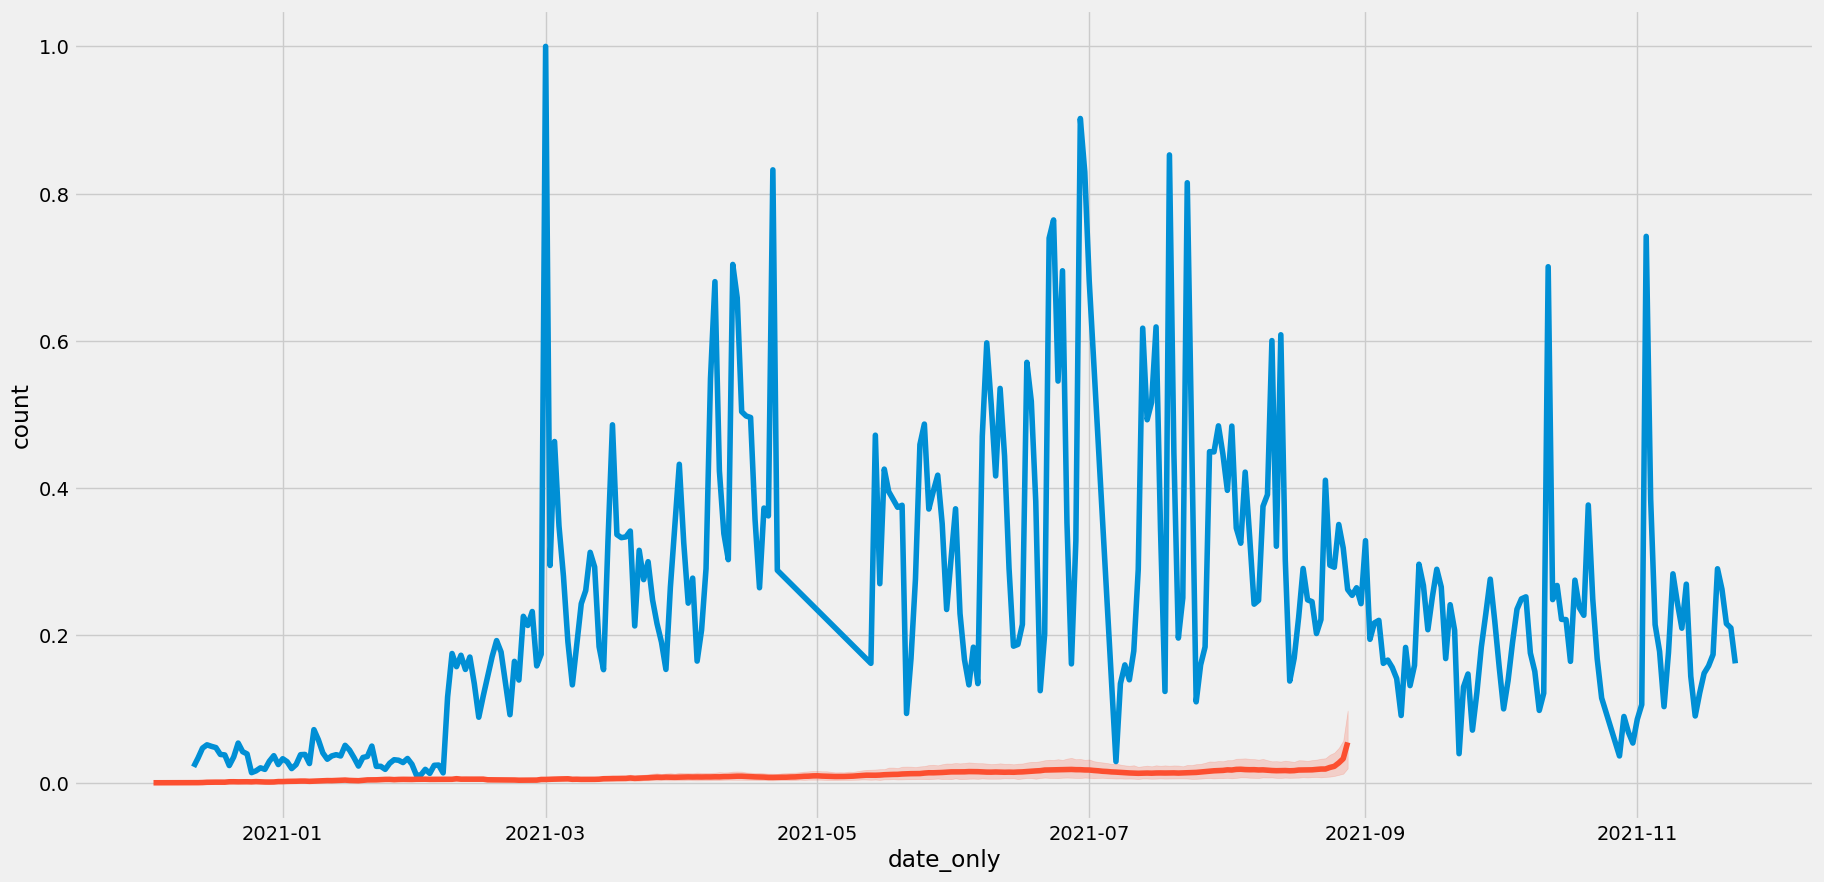

In [204]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=tweets_agg_df['date_only'], y=tweets_agg_df['count']/tweets_agg_df['count'].max(), data=tweets_agg_df)
sns.lineplot(x=vaccines['date'], y=vaccines['daily_vaccinations']/vaccines['daily_vaccinations'].max(), data=vaccines)
plt.show()

***Возьмем первое полугодие 2021-го***

In [205]:
tweets_agg_df['date_only']=pd.to_datetime(tweets_agg_df['date_only'])

In [206]:
tweets_agg_df=tweets_agg_df[(tweets_agg_df['date_only'] >= '2021-01-01') & (tweets_agg_df['date_only'] <= '2021-07-01')]

In [207]:
vaccines=vaccines[(vaccines['date'] >= '2021-01-01') & (vaccines['date'] <= '2021-07-01')].groupby([vaccines['date'].dt.date]).sum()

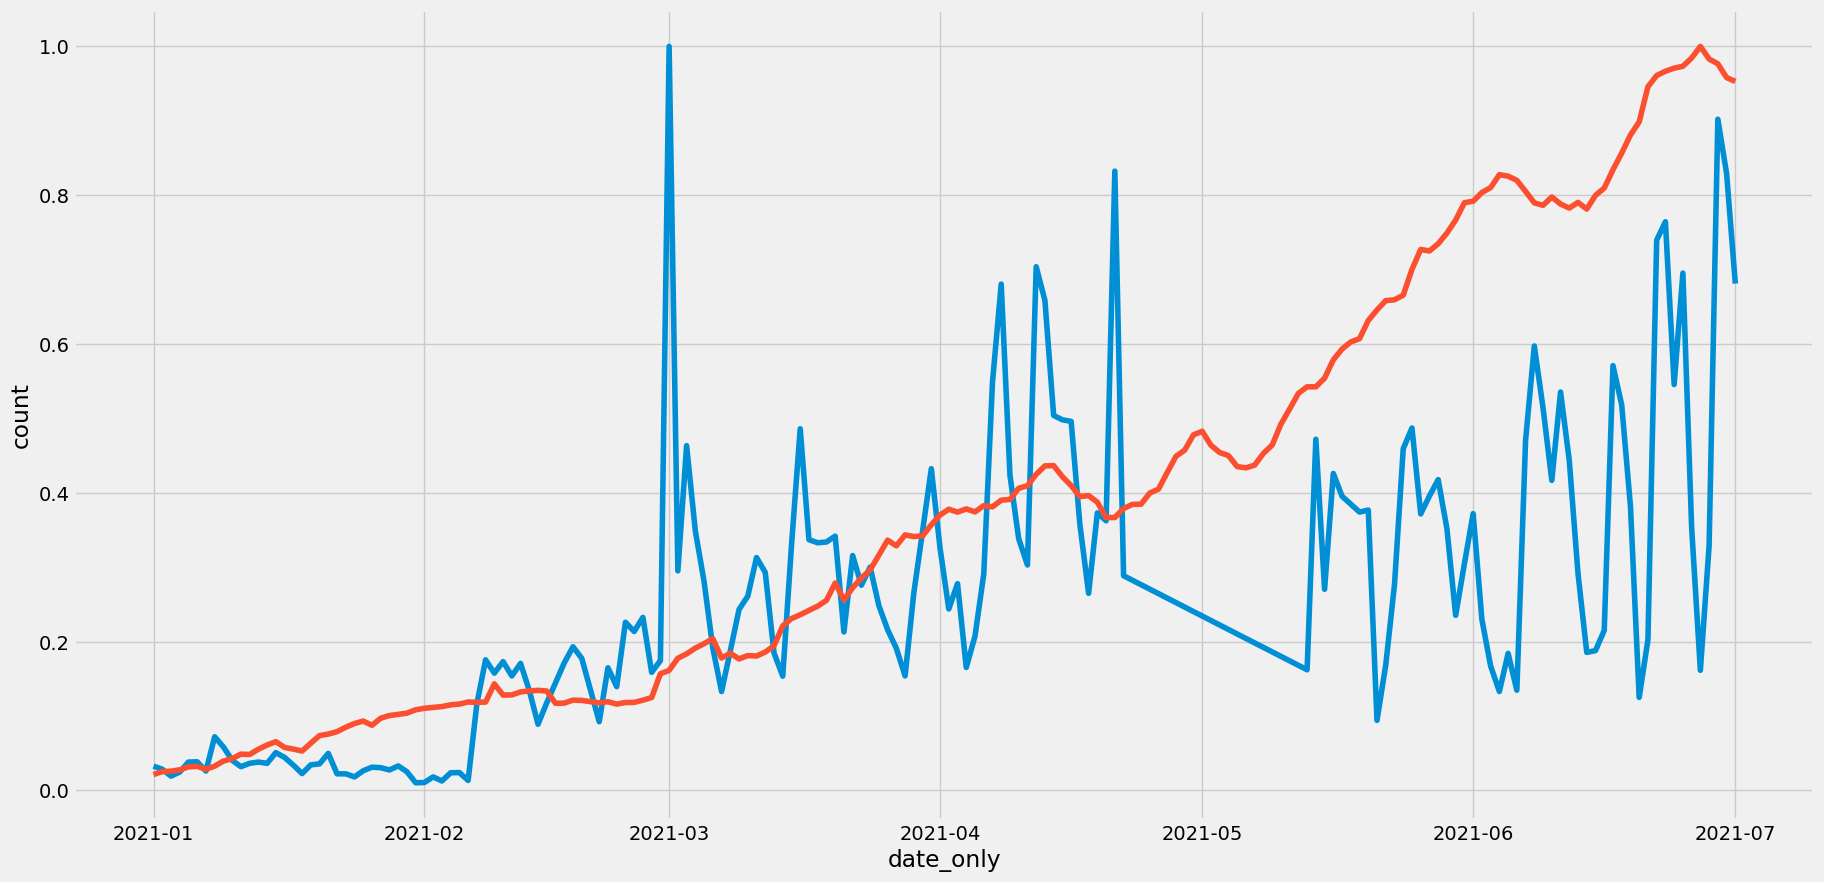

In [208]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=tweets_agg_df['date_only'], y=tweets_agg_df['count']/tweets_agg_df['count'].max(), data=tweets_agg_df['count'])
sns.lineplot(data=vaccines['daily_vaccinations']/vaccines['daily_vaccinations'].max())
plt.show()

In [214]:
tweets_agg_df = tweets_agg_df.set_index(['date_only'])

In [215]:
tweets_agg_df

,count
date_only,
2021-01-01,95
2021-01-02,83
2021-01-03,56
2021-01-04,72
2021-01-05,111
...,...
2021-06-27,470
2021-06-28,957
2021-06-29,2626


In [247]:
vaccines['daily_vaccinations'][tweets_agg_df.index]

date_only
2021-01-01      3818590.0
2021-01-02      4504894.0
2021-01-03      4613597.0
2021-01-04      4934845.0
2021-01-05      5653379.0
                 ...     
2021-06-27    178349163.0
2021-06-28    175331704.0
2021-06-29    174173353.0
2021-06-30    170874596.0
2021-07-01    169947643.0
Name: daily_vaccinations, Length: 162, dtype: float64

***Тест Грейнджера***

Нуль гипотеза: пусть x (Твиты) НЕ являются причиной y (вакцины)

In [269]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(pd.DataFrame([tweets_agg_df['count'], vaccines['daily_vaccinations'][tweets_agg_df.index]]).transpose(), maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3620  , p=0.0015  , df_denom=152, df_num=3
ssr based chi2 test:   chi2=16.8267 , p=0.0008  , df=3
likelihood ratio test: chi2=15.9945 , p=0.0011  , df=3
parameter F test:         F=5.3620  , p=0.0015  , df_denom=152, df_num=3


{3: ({'ssr_ftest': (5.361967522719098, 0.001547893259536145, 152.0, 3),
   'ssr_chi2test': (16.826700712743488, 0.0007671725346067496, 3),
   'lrtest': (15.994549776987697, 0.0011369056381917726, 3),
   'params_ftest': (5.361967522860188, 0.0015478932592561882, 152.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

В результате работы ssr based F test F получилось равным 5.3620 при p =  0.0015

Значит, мы можем отклонить нуль-гипотезу и заключить, что знание о количестве твитов может быть полезным при предсказании количества вакцинированных.

In [270]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(pd.DataFrame([tweets_agg_df['count'], vaccines['daily_vaccinations'][tweets_agg_df.index]]).transpose(), maxlag=[5])


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0072  , p=0.0810  , df_denom=146, df_num=5
ssr based chi2 test:   chi2=10.7924 , p=0.0557  , df=5
likelihood ratio test: chi2=10.4376 , p=0.0637  , df=5
parameter F test:         F=2.0072  , p=0.0810  , df_denom=146, df_num=5


{5: ({'ssr_ftest': (2.0072411390418954, 0.08095082113586453, 146.0, 5),
   'ssr_chi2test': (10.792358179095121, 0.05565593062189441, 5),
   'lrtest': (10.437587085240011, 0.06374439307778597, 5),
   'params_ftest': (2.0072411390831375, 0.0809508211299545, 146.0, 5.0)},
   array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

В результате работы ssr based F test F получилось равным 2.0072 при p =  0.0810

Значит, мы можем принять нуль-гипотезу и заключить, что знание о количестве твитов НЕ может быть полезным при предсказании количества вакцинированных.

In [271]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(pd.DataFrame([tweets_agg_df['count'], vaccines['daily_vaccinations'][tweets_agg_df.index]]).transpose(), maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2888  , p=0.2432  , df_denom=131, df_num=10
ssr based chi2 test:   chi2=14.9540 , p=0.1337  , df=10
likelihood ratio test: chi2=14.2634 , p=0.1613  , df=10
parameter F test:         F=1.2888  , p=0.2432  , df_denom=131, df_num=10


{10: ({'ssr_ftest': (1.2887997985899495, 0.24316470056672065, 131.0, 10),
   'ssr_chi2test': (14.954012930203996, 0.13374747890256253, 10),
   'lrtest': (14.26335805994313, 0.16131439310813198, 10),
   'params_ftest': (1.2887997985807094, 0.2431647005718822, 131.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

В результате работы ssr based F test F получилось равным 1.2888 при p =  0.2432

Значит, мы можем принять нуль-гипотезу и заключить, что знание о количестве твитов НЕ может быть полезным при предсказании количества вакцинированных.

***Обратный тест Грейнджера***

Нуль гипотеза: пусть x (Вакцины) НЕ являются причиной y (Твиты)

In [267]:
grangercausalitytests(pd.DataFrame([vaccines['daily_vaccinations'][tweets_agg_df.index], tweets_agg_df['count']]).transpose(), maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.2078  , p=0.0005  , df_denom=152, df_num=3
ssr based chi2 test:   chi2=19.4812 , p=0.0002  , df=3
likelihood ratio test: chi2=18.3770 , p=0.0004  , df=3
parameter F test:         F=6.2078  , p=0.0005  , df_denom=152, df_num=3


{3: ({'ssr_ftest': (6.207835622989812, 0.000525523154217998, 152.0, 3),
   'ssr_chi2test': (19.481168369514084, 0.0002173958274944887, 3),
   'lrtest': (18.37704416246561, 0.00036770836106598864, 3),
   'params_ftest': (6.207835622989831, 0.0005255231542179848, 152.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

В результате работы ssr based F test F получилось равным 6.2078 при p =  .0005

Значит, мы можем отклонить нуль-гипотезу и заключить, что знание о количестве вакцин может быть полезным при предсказании количества твитов.

In [272]:
grangercausalitytests(pd.DataFrame([vaccines['daily_vaccinations'][tweets_agg_df.index], tweets_agg_df['count']]).transpose(), maxlag=[5])


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.8646  , p=0.0026  , df_denom=146, df_num=5
ssr based chi2 test:   chi2=20.7789 , p=0.0009  , df=5
likelihood ratio test: chi2=19.5143 , p=0.0015  , df=5
parameter F test:         F=3.8646  , p=0.0026  , df_denom=146, df_num=5


{5: ({'ssr_ftest': (3.8646191601769617, 0.002559091191352282, 146.0, 5),
   'ssr_chi2test': (20.77894548451312, 0.0008917643335384374, 5),
   'lrtest': (19.514329737929074, 0.001540972785558278, 5),
   'params_ftest': (3.8646191601769972, 0.002559091191352124, 146.0, 5.0)},
   array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

В результате работы ssr based F test F получилось равным 3.8646 при p =  0.0026

Значит, мы можем отклонить нуль-гипотезу и заключить, что знание о количестве вакцин может быть полезным при предсказании количества твитов.

In [273]:
grangercausalitytests(pd.DataFrame([vaccines['daily_vaccinations'][tweets_agg_df.index], tweets_agg_df['count']]).transpose(), maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4900  , p=0.0004  , df_denom=131, df_num=10
ssr based chi2 test:   chi2=40.4949 , p=0.0000  , df=10
likelihood ratio test: chi2=35.9007 , p=0.0001  , df=10
parameter F test:         F=3.4900  , p=0.0004  , df_denom=131, df_num=10


{10: ({'ssr_ftest': (3.49001681834037, 0.0004225362248929511, 131.0, 10),
   'ssr_chi2test': (40.494851632651624, 1.3860499890846226e-05, 10),
   'lrtest': (35.90071093928691, 8.754787503340689e-05, 10),
   'params_ftest': (3.4900168183410427, 0.0004225362248920667, 131.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

В результате работы ssr based F test F получилось равным 3.4900 при p =  0.0004

Значит, мы можем отклонить нуль-гипотезу и заключить, что знание о количестве вакцин может быть полезным при предсказании количества твитов.

***Вероятнее всего, что твиты стали следствием вакцин, а не наоборот***



***Оценим стационарность временного ряда***

count    1.820000e+02
mean     6.861788e+07
std      5.137927e+07
min      3.818590e+06
25%      2.126531e+07
50%      6.541543e+07
75%      1.051543e+08
max      1.783492e+08
Name: daily_vaccinations, dtype: float64

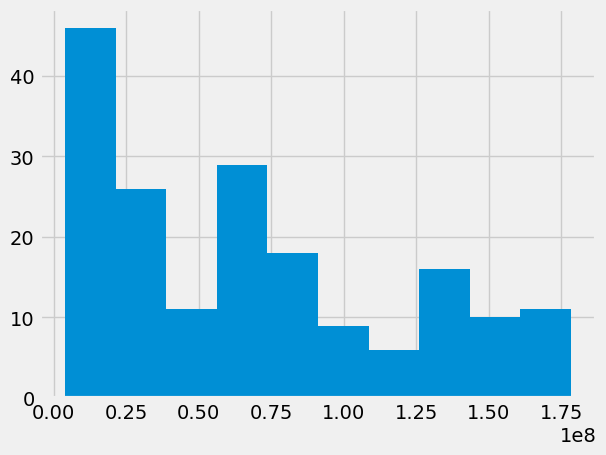

In [276]:
itog = vaccines['daily_vaccinations'].describe()
vaccines['daily_vaccinations'].hist()
itog

Как можно заметить из характеристик и гистограммы, ряд у нас не очень однородный, однако имеет относительно небольшой разброс о чем свидетельствует коэффициент вариации V. В нашем случае он равен:

In [281]:
print('V = %f' % (itog['std']/itog['mean']))

V = 0.748774


Для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле statsmodels есть функция adfuller(). Возьмем 5%-ую уверенность за искомую:

In [291]:
test = sm.tsa.adfuller(vaccines['daily_vaccinations'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  1.6461773856200481
p-value:  0.9979897071693794
Critical values:  {'1%': -3.4685016947910636, '5%': -2.8782983668563396, '10%': -2.57570415906989}
есть единичные корни, ряд не стационарен


***Ряд не стационарен***

***Проверим второй***

adf:  -1.2794662070048415
p-value:  0.6385134141755673
Critical values:  {'1%': -3.4732590518613002, '5%': -2.880374082105334, '10%': -2.5768120811654525}
есть единичные корни, ряд не стационарен


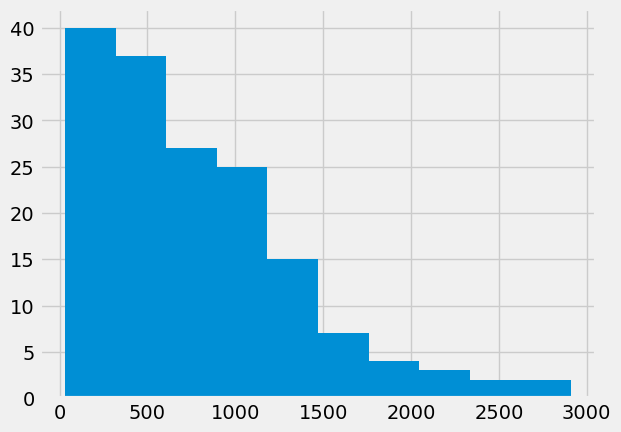

In [289]:
itog = tweets_agg_df['count'].describe()
tweets_agg_df['count'].hist()
itog


test = sm.tsa.adfuller(tweets_agg_df['count'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

***Ряд не стационарен***

***Оба ряда не стационарны -> проверяем коинтегрированность***

In [304]:
from statsmodels.tsa.stattools import coint
ALPHA = 0.05

score, pvalue, _ = coint(vaccines['daily_vaccinations'][tweets_agg_df.index], tweets_agg_df['count'], maxlag=3)
pvalue

print(f'cointegration: score: {score:.2f}')
print(f'cointegration: p-value: {pvalue:.10f}')
print("cointegrated - there MUST be Granger causality" if pvalue < ALPHA else "NOT cointegrated")

cointegration: score: -1.96
cointegration: p-value: 0.5483097032
NOT cointegrated


In [305]:
score, pvalue, _ = coint(vaccines['daily_vaccinations'][tweets_agg_df.index], tweets_agg_df['count'], maxlag=5)
pvalue

print(f'cointegration: score: {score:.2f}')
print(f'cointegration: p-value: {pvalue:.10f}')
print("cointegrated - there MUST be Granger causality" if pvalue < ALPHA else "NOT cointegrated")

cointegration: score: -1.08
cointegration: p-value: 0.8874172779
NOT cointegrated


In [306]:
score, pvalue, _ = coint(vaccines['daily_vaccinations'][tweets_agg_df.index], tweets_agg_df['count'], maxlag=10)
pvalue

print(f'cointegration: score: {score:.2f}')
print(f'cointegration: p-value: {pvalue:.10f}')
print("cointegrated - there MUST be Granger causality" if pvalue < ALPHA else "NOT cointegrated")

cointegration: score: -0.80
cointegration: p-value: 0.9351817441
NOT cointegrated


***Процессы не коинтегрированы***